Patient Data with Predictions:
         Age  Cholesterol  Blood Pressure  Max Heart Rate     Exang   Oldpeak  \
0  -1.566362    -2.277608       -1.118034        1.141195 -0.696419 -0.840771   
1   0.638422     0.439057       -1.118034       -0.876275 -0.696419 -0.840771   
2  -1.566362     0.439057        0.894427       -0.876275 -0.696419 -0.840771   
3   0.638422     0.439057        0.894427        1.141195 -0.696419  1.189384   
4   0.638422     0.439057       -1.118034       -0.876275 -0.696419 -0.840771   
5  -1.566362     0.439057        0.894427        1.141195 -0.696419  1.189384   
6   0.638422    -2.277608        0.894427       -0.876275 -0.696419 -0.840771   
7   0.638422     0.439057       -1.118034       -0.876275 -0.696419 -0.840771   
8   0.638422     0.439057        0.894427       -0.876275  1.435916  1.189384   
9   0.638422     0.439057        0.894427       -0.876275  1.435916 -0.840771   
10  0.638422     0.439057        0.894427       -0.876275 -0.696419 -0.840771 

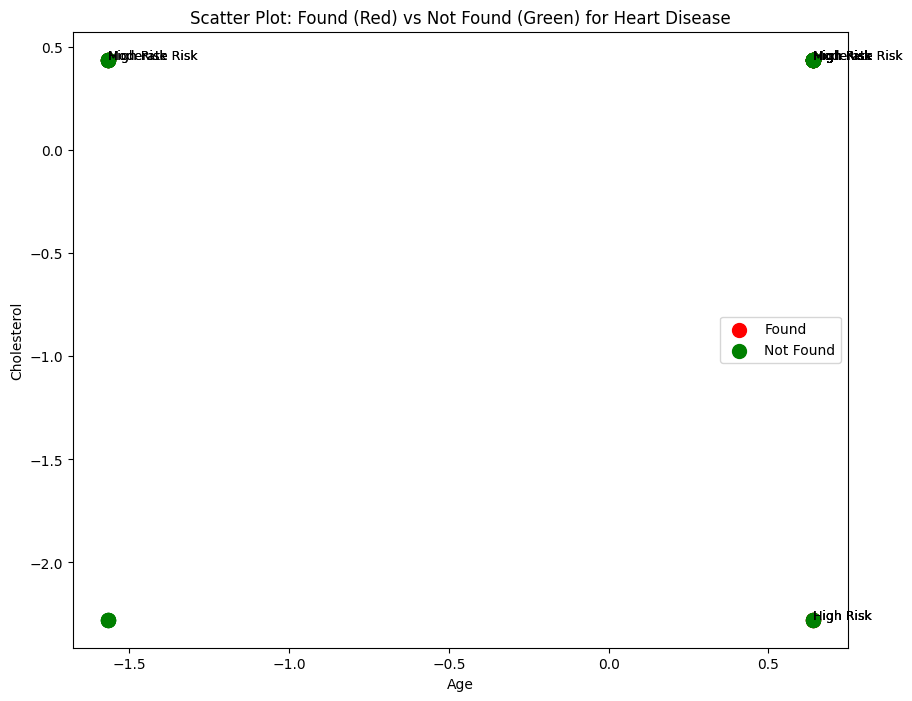


Accuracy: 0.85

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88        36
           1       0.83      0.79      0.81        24

    accuracy                           0.85        60
   macro avg       0.85      0.84      0.84        60
weighted avg       0.85      0.85      0.85        60



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", 
           "oldpeak", "slope", "ca", "thal", "target"]

# Load data
data = pd.read_csv(url, header=None, names=columns, na_values="?")

# Drop rows with missing values
data = data.dropna()

# Target encoding: 0 (no disease), 1-4 (disease present)
data['target'] = data['target'].apply(lambda x: 1 if x > 0 else 0)

# Step 2: Apply thresholds to categorize risk levels
data['age_high_risk'] = data.apply(
    lambda row: 1 if (row['age'] > 45 and row['sex'] == 1) or (row['age'] > 55 and row['sex'] == 0) else 0, axis=1
)
data['chol_high'] = data['chol'].apply(lambda x: 1 if x >= 200 else 0)
data['bp_high'] = data['trestbps'].apply(lambda x: 1 if x >= 130 else 0)
data['thalach_low'] = data['thalach'].apply(lambda x: 1 if x < 150 else 0)
data['exang_positive'] = data['exang']  # Already binary, no transformation needed
data['oldpeak_high'] = data['oldpeak'].apply(lambda x: 1 if x > 1.0 else 0)
data['ca_high'] = data['ca'].apply(lambda x: 1 if x >= 1 else 0)
data['thal_risk'] = data['thal'].apply(lambda x: 1 if x in [6, 7] else 0)

# Define feature set using transformed features
X = data[['age_high_risk', 'chol_high', 'bp_high', 'thalach_low', 
          'exang_positive', 'oldpeak_high', 'ca_high', 'thal_risk']]
y = data['target']

# Step 3: Preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 5: Predictions and threshold for risk levels
threshold = 0.5
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= threshold).astype(int)

# Risk level based on probability
def risk_level(prob):
    if prob < 0.4:
        return "Low Risk"
    elif 0.4 <= prob < 0.7:
        return "Moderate Risk"
    else:
        return "High Risk"

# Prepare final results DataFrame for visualization
results = pd.DataFrame({
    'Age': X_test[:, 0],
    'Cholesterol': X_test[:, 1],
    'Blood Pressure': X_test[:, 2],
    'Max Heart Rate': X_test[:, 3],
    'Exang': X_test[:, 4],
    'Oldpeak': X_test[:, 5],
    'CA': X_test[:, 6],
    'Thal': X_test[:, 7],
    'Probability': y_pred_prob,
    'Heart Disease': ["Found" if pred else "Not Found" for pred in y_pred],
    'Risk Level': [risk_level(prob) for prob in y_pred_prob]
})

# Print all the data (patients' info along with predictions)
print("Patient Data with Predictions:")
print(results)

# 1. Scatter Plot: Found (Red) and Not Found (Green)
plt.figure(figsize=(10, 8))

# Plot points where Heart Disease is found (Red)
found_data = results[results['Heart Disease'] == 'Found']
plt.scatter(found_data['Age'], found_data['Cholesterol'], c='red', label='Found', s=100)

# Plot points where Heart Disease is not found (Green)
not_found_data = results[results['Heart Disease'] == 'Not Found']
plt.scatter(not_found_data['Age'], not_found_data['Cholesterol'], c='green', label='Not Found', s=100)

# Annotate risk levels for patients with found disease
for i, row in found_data.iterrows():
    plt.text(row['Age'], row['Cholesterol'], f"{row['Risk Level']}", fontsize=9, color='black')

plt.title('Scatter Plot: Found (Red) vs Not Found (Green) for Heart Disease')
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.legend()
plt.show()

# Step 6: Evaluate and display results
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
